In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from tensorflow import keras

plt.rc("figure", figsize=(16,8))
plt.rc("font", size=13)

print("pandas version: " + pd.__version__)
print("numpy version: " + np.__version__)
print("tensorflow version: " + tf.__version__)

pandas version: 1.2.4
numpy version: 1.18.5
tensorflow version: 2.3.1


LSTM: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

In [2]:
df = pd.read_csv("../data/clean/trips_with_weather.csv", parse_dates=["date_from", "date_until"])
df.set_index("date_until", inplace=True)

In [3]:
df.head(3)

,bike_id,user_id,date_from,start_station_name,start_station_id,end_station_name,end_station_id,booked_via,duration_in_min,distance_in_km,speed_in_kmh,precip_intensity,precip_probability,precip_type,temperature,humidity,wind_speed,wind_bearing,uv_index,visibility
date_until,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:50:14,143517,A821059B555C7764A2FF801180874A2FCB326222,2014-01-01 00:34:54,U-Bahn Baumwall,214170,Mönckebergstraße / Rosenstraße,131880,iPhone SRH,16,1.293661,4.851229,0.0,0.0,none,1.93,0.81,3.91,161.0,0,9.988
2014-01-01 00:34:41,120450,2C6FD52D5611B4DAC29E5197B67979D583685948,2014-01-01 00:27:47,Lange Reihe / Lohmühlenpark,138385,Hauptbahnhof Ost / Hachmannplatz,131873,IVR,7,0.786254,6.739322,0.0,0.0,none,1.93,0.81,3.91,161.0,0,9.988
2014-01-01 00:56:32,117503,253528F56A582E05F13D8A89B20A23800DDEBEF2,2014-01-01 00:49:02,Sternschanze / Eingang Dänenweg,139501,Bahnhof Dammtor Süd / Marseiller Straße,138382,iPhone SRH,8,1.422850,10.671375,0.0,0.0,none,1.93,0.81,3.91,161.0,0,9.988


In [26]:
SAMPLE_START_DATE = "2015-07-01"
SAMPLE_END_DATE = "2016-12-31 23:59:59"

In [27]:
sample_df = combined_df[
    pd.Timestamp(SAMPLE_START_DATE):pd.Timestamp(SAMPLE_END_DATE)
][["check_ins", "temperature", "humidity", "uv_index", "wind_speed"]].resample("H").agg({
    "check_ins": "sum",
    "temperature": "mean",
    "humidity": "mean",
    "uv_index": "mean",
    "wind_speed": "mean"
})
sample_df.interpolate(inplace=True)

sample_df.head(3)

,check_ins,temperature,humidity,uv_index,wind_speed
datetime,,,,,
2015-07-01 00:00:00,160,18.68,0.62,0.0,2.84
2015-07-01 01:00:00,112,17.59,0.66,0.0,2.92
2015-07-01 02:00:00,40,17.04,0.68,0.0,3.72


In [28]:
sample_df.tail(3)

,check_ins,temperature,humidity,uv_index,wind_speed
datetime,,,,,
2016-12-31 21:00:00,62,3.17,0.99,0.0,4.46
2016-12-31 22:00:00,80,3.18,0.98,0.0,3.04
2016-12-31 23:00:00,119,3.17,0.99,0.0,2.85


In [29]:
# Normalize data

feature_columns = ["temperature", "humidity", "uv_index", "wind_speed"]
label_columns = ["check_ins"]

feature_scaler = MinMaxScaler()
label_scaler = MinMaxScaler()

feature_scaler.fit(sample_df[feature_columns])
label_scaler.fit(sample_df[label_columns])

sample_df_scaled = sample_df.reset_index().drop(columns=["datetime"]).copy()

sample_df_scaled["temperature"] = feature_scaler.fit_transform(sample_df["temperature"].values.reshape(-1, 1))
sample_df_scaled["humidity"] = feature_scaler.fit_transform(sample_df["humidity"].values.reshape(-1, 1))
sample_df_scaled["uv_index"] = feature_scaler.fit_transform(sample_df["uv_index"].values.reshape(-1, 1))
sample_df_scaled["wind_speed"] = feature_scaler.fit_transform(sample_df["wind_speed"].values.reshape(-1, 1))

sample_df_scaled["check_ins"] = label_scaler.fit_transform(sample_df["check_ins"].values.reshape(-1, 1))

sample_df_scaled.head(3)

,check_ins,temperature,humidity,uv_index,wind_speed
0,0.116279,0.602510,0.506494,0.0,0.210370
1,0.081395,0.578086,0.558442,0.0,0.216296
2,0.029070,0.565763,0.584416,0.0,0.275556


In [30]:
sequence_length = 24
predict_next = 1

In [31]:
# Split into training, testing and validation data sets
train_data, test_data = train_test_split(
    sample_df_scaled, shuffle=False, train_size=0.8, test_size=0.2
)

In [32]:
def reshape_data(data):
    features = data[feature_columns]
    labels = data[label_columns]
    x = []
    y = []
    for index in range(len(features) - sequence_length):
        feature_sequence = features.iloc[index : (index + sequence_length)].to_numpy()
        label_value = labels.iloc[index + sequence_length]
        x.append(feature_sequence)
        y.append(label_value)
    return np.array(x), np.array(y)

In [33]:
train_x, train_y = reshape_data(train_data)
test_x, test_y = reshape_data(test_data)

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(10536, 24, 4) (10536, 1)
(2616, 24, 4) (2616, 1)


In [34]:
input_shape = (train_x.shape[1], train_x.shape[2])
input_shape

(24, 4)

In [35]:
model = keras.Sequential()
lstm_1 = keras.layers.LSTM(
    units=128,
    activation="relu",
    input_shape=input_shape,
    return_sequences=True
)
lstm_2 = keras.layers.LSTM(
    units=32,
    activation="relu",
    return_sequences=True
)
dropout = keras.layers.Dropout(0.2)
dense = keras.layers.Dense(1)

model.add(lstm_1)
#model.add(lstm_2)
model.add(dropout)
model.add(dense)

model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 24, 128)           68096     
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 128)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 24, 1)             129       
Total params: 68,225
Trainable params: 68,225
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
297/297 [==============================] - 5s 16ms/step - loss: 0.0283 - val_loss: 0.0377
Epoch 2/10
297/297 [==============================] - 5s 15ms/step - loss: 0.0231 - val_loss: 0.0287
Epoch 3/10
297/297 [==============================] - 4s 14ms/step - loss: 0.0197 - val_loss: 0.0272
Epoch 4/10
297/297 [==============================] - 4s 14ms/step - loss: 0.0184 - val_loss: 0.0253
Epoch 5/10
297/297 [==============================] - 5s 16ms/step - loss: 0.0174 - val_loss: 0.0232
Epoch 6/10
297/297 [==============================] - 4s 14ms/step - loss: 0.0168 - val_loss: 0.0221
Epoch 7/10
297/297 [==============================] - 4s 15ms/step - loss: 0.0164 - val_loss: 0.0214
Epoch 8/10
297/297 [==============================] - 4s 14ms/step - loss: 0.0161 - val_loss: 0.0210
Epoch 9/10
297/297 [==============================] - 4s 15ms/step - loss: 0.0157 - val_loss: 0.0205
Epoch 10/10
297/297 [==============================] - 4s 14ms/step - loss: 0.0156 - val_lo

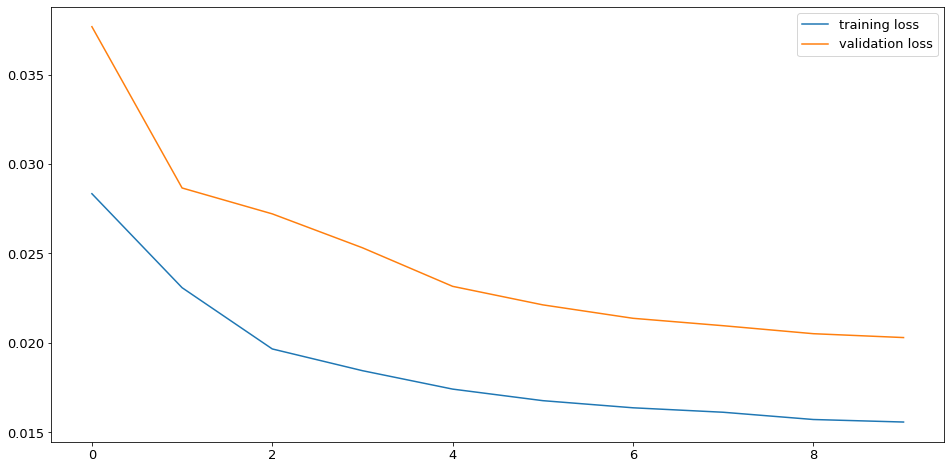

In [36]:
history = model.fit(
    train_x,
    train_y,
    validation_split=0.1,
    epochs=10,
    batch_size=32,
    shuffle=False,
    #verbose=1
)

plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.show()

MAPE: 2064837365474710.2


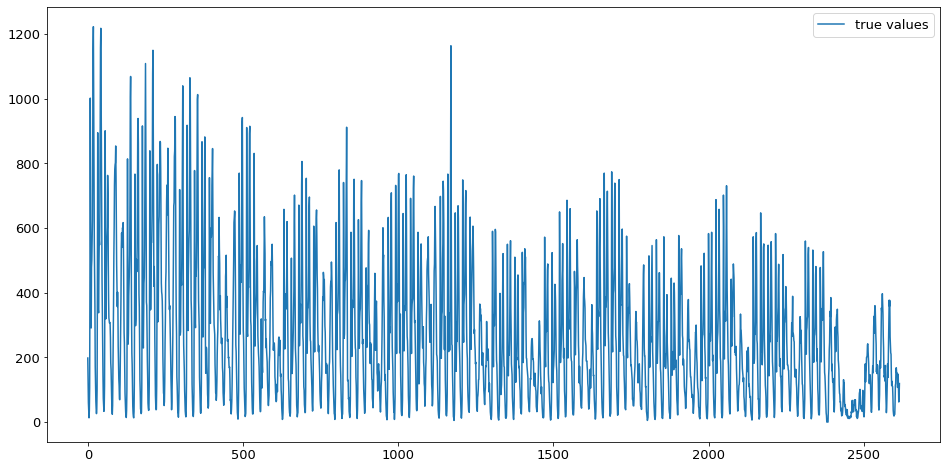

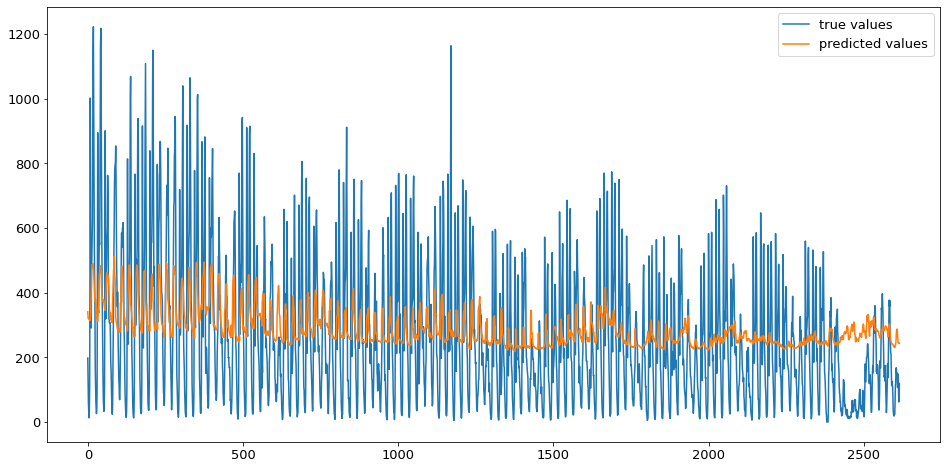

In [46]:
scaled_predictions = model.predict(test_x)

test_y_inv = label_scaler.inverse_transform(test_y)
predictions = label_scaler.inverse_transform(scaled_predictions[:,0])

mape = mean_absolute_percentage_error(test_y_inv, predictions)
print("MAPE: %s" %(mape))

plt.plot(test_y_inv, label="true values")
plt.legend()
plt.show()
plt.plot(test_y_inv, label="true values")
plt.plot(predictions, label="predicted values")
plt.legend()
plt.show()